In [20]:
import numpy as np
import pandas as pd
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import string
import random

Load the JSON file

In [21]:
with open('intents2_mh.json') as file:
    data = json.load(file)

In [22]:
tags = []
patterns = []
responses = {}

In [23]:
for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['patterns']:
        patterns.append(lines)
        tags.append(intent['tag'])

In [24]:
data = pd.DataFrame({"patterns": patterns, "tags": tags})

Lowercase, remove punctuation, lemmatize, remove whitespace, stopwords

In [25]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [26]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

In [27]:
data['patterns'] = data['patterns'].apply(preprocess_text)

Feature Extraction

In [28]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['patterns'])

Tokenization

In [29]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])

Convert text to sequences

In [30]:
sequences = tokenizer.texts_to_sequences(data['patterns'])

Pad sequences

In [31]:
x_train = pad_sequences(sequences)

Give One Hot Encode to the input

In [32]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
input_shape = x_train.shape[1]

Define the vocab

In [33]:
vocabulary = len(tokenizer.word_index)
output_length = le.classes_.shape[0]

Define hyperparameters

In [34]:
learning_rate = 0.001
batch_size = 64
epochs = 1000

Define neural network architecture

In [35]:
from keras.layers import LSTM

# Input layer
input_layer = Input(shape=(input_shape,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocabulary+1, output_dim=10)(input_layer)

# LSTM layer
lstm_layer = LSTM(10, return_sequences=True)(embedding_layer)

# Flatten layer
flatten_layer = Flatten()(lstm_layer)

# Output layer
output_layer = Dense(output_length, activation="softmax")(flatten_layer)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Summary of the model
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 6, 10)             2360      
                                                                 
 lstm_1 (LSTM)               (None, 6, 10)             840       
                                                                 
 flatten_1 (Flatten)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
Total params: 6,860
Trainable params: 6,860
Non-trainable params: 0
_________________________________________________________________


Compile the model with hyperparameters

In [36]:
import keras

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              metrics=['accuracy'])


Split the dataset into training and validation sets

In [37]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Train the model and store the history

In [39]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Epoch 1/1000
3/3 [==============================] - 0s 64ms/step - loss: 4.0938 - accuracy: 0.0278 - val_loss: 4.0967 - val_accuracy: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 0s 51ms/step - loss: 4.0924 - accuracy: 0.0278 - val_loss: 4.0981 - val_accuracy: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 0s 36ms/step - loss: 4.0910 - accuracy: 0.0278 - val_loss: 4.0992 - val_accuracy: 0.0000e+00
Epoch 4/1000
3/3 [==============================] - 0s 48ms/step - loss: 4.0898 - accuracy: 0.0278 - val_loss: 4.1004 - val_accuracy: 0.0000e+00
Epoch 5/1000
3/3 [==============================] - 0s 47ms/step - loss: 4.0885 - accuracy: 0.0278 - val_loss: 4.1015 - val_accuracy: 0.0000e+00
Epoch 6/1000
3/3 [==============================] - 0s 43ms/step - loss: 4.0873 - accuracy: 0.0278 - val_loss: 4.1027 - val_accuracy: 0.0000e+00
Epoch 7/1000
3/3 [==============================] - 0s 45ms/step - loss: 4.0860 - accuracy: 0.0278 - val_loss: 4.1039 - val_accura

In [40]:
model.save('RNN_LSTM_model_6.h5')

Metrics

In [41]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

In [42]:
print(f"Final Training Accuracy: {train_acc}")
print(f"Final Validation Accuracy: {val_acc}")
print(f"Final Training Loss: {train_loss}")
print(f"Final Validation Loss: {val_loss}")

Final Training Accuracy: 0.9861111044883728
Final Validation Accuracy: 0.1111111119389534
Final Training Loss: 0.05166984349489212
Final Validation Loss: 6.937075138092041


Plot training and validation accuracy

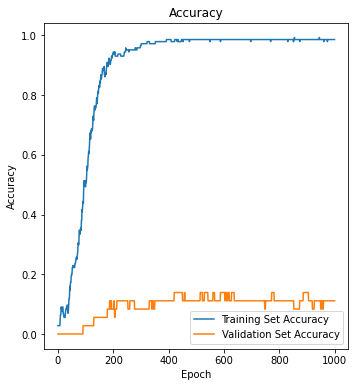

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Set Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Set Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Plot training and validation loss

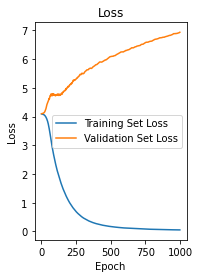

In [44]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Set Loss')
plt.plot(history.history['val_loss'], label='Validation Set Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [45]:
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

Interactive chat with the trained model

In [53]:
from keras.models import load_model

model = load_model("RNN_LSTM_model_6.h5")

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

while True:
    texts_p = []
    prediction_input = input('You: ')

    # Print user input
    print("User input:", prediction_input)

    # Text preprocessing
    prediction_input = preprocess_text(prediction_input)
    texts_p.append(prediction_input)

    # Tokenization and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(1, -1)
    prediction_input = pad_sequences(prediction_input, maxlen=input_shape)

    # Getting output
    output = model.predict(prediction_input)
    output = output.argmax()

    # Finding the right tag and predict
    response_tag = le.inverse_transform([output])[0]
    print("Response: ", random.choice(responses[response_tag]))
    if response_tag == "goodbye":
        break


User input: when is it appropriate to express gratitude?
1/1 [==============================] - 0s 429ms/step
Response:  Anytime!
User input: what strategies help alleviate anxiety?
1/1 [==============================] - 0s 21ms/step
Response:  Focus on your breathing.
User input: i need to overcome my loneliness, what should i do?
1/1 [==============================] - 0s 23ms/step
Response:  Connect with friends or family.
User input: i need to do meditation, can you tell me?
1/1 [==============================] - 0s 40ms/step
Response:  Start with deep breathing and focus on the present moment.
User input: i have to deal with my relationship, can you help me?
1/1 [==============================] - 0s 25ms/step
Response:  Set boundaries and prioritize your well-being in relationships.
User input: 
1/1 [==============================] - 0s 28ms/step
Response:  Meditation can reduce stress, improve focus, and promote emotional well-being.


KeyboardInterrupt: Interrupted by user